In [17]:
# import cv2
# vidcap = cv2.VideoCapture('moving_car.mp4')
# def getFrame(sec):
#     vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
#     hasFrames,image = vidcap.read()
#     if hasFrames:
#         cv2.imwrite("image"+str(count)+".jpg", image)     # save frame as JPG file
#     return hasFrames

# sec = 0
# frameRate = 0.01 #//it will capture image in each 0.05 second
# count=1
# success = getFrame(sec)
# while success:
#     count = count + 1
#     sec = sec + frameRate
#     sec = round(sec, 2)
#     success = getFrame(sec)

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import gridspec
from numpy.fft import rfft2, fft2, irfft2, ifft2,fftshift,ifftshift
from scipy import signal
import cv2
from skimage import restoration



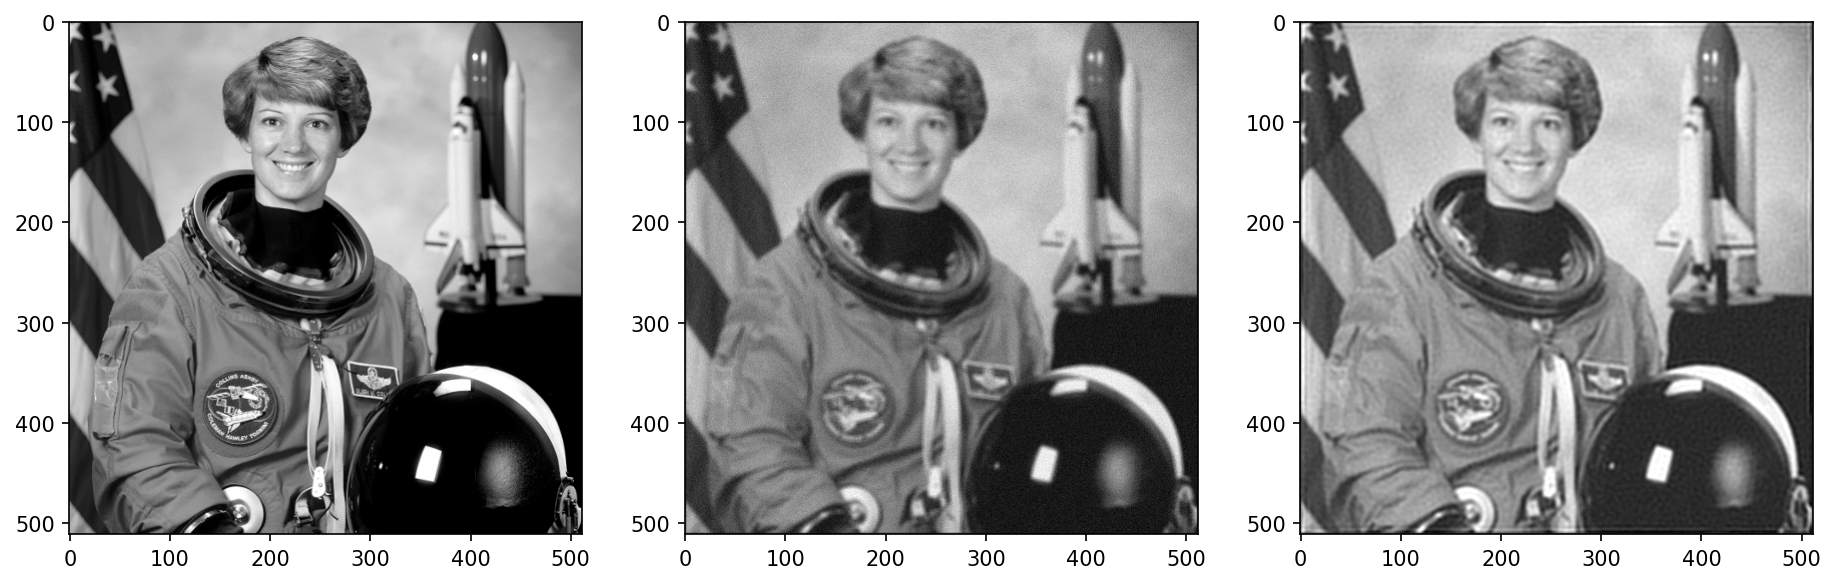

In [150]:
from skimage import color, data, restoration
img_ = color.rgb2gray(data.astronaut())
from scipy.signal import convolve2d

n = 5
psf = np.ones((n, n)) / 5**2
img = convolve2d(img_, psf, 'same')
rng = np.random.default_rng()
img += 0.1 * img.std() * rng.standard_normal(img.shape)
deconvolved_img = restoration.wiener(img, psf, 0.1)

cmap = 'gray'
plt.figure(dpi = 150, figsize = (15,5))
plt.subplot(131)
plt.imshow(img_, cmap = cmap)
plt.subplot(132)
plt.imshow(img, cmap = cmap)
plt.subplot(133)
plt.imshow(deconvolved_img, cmap =cmap)

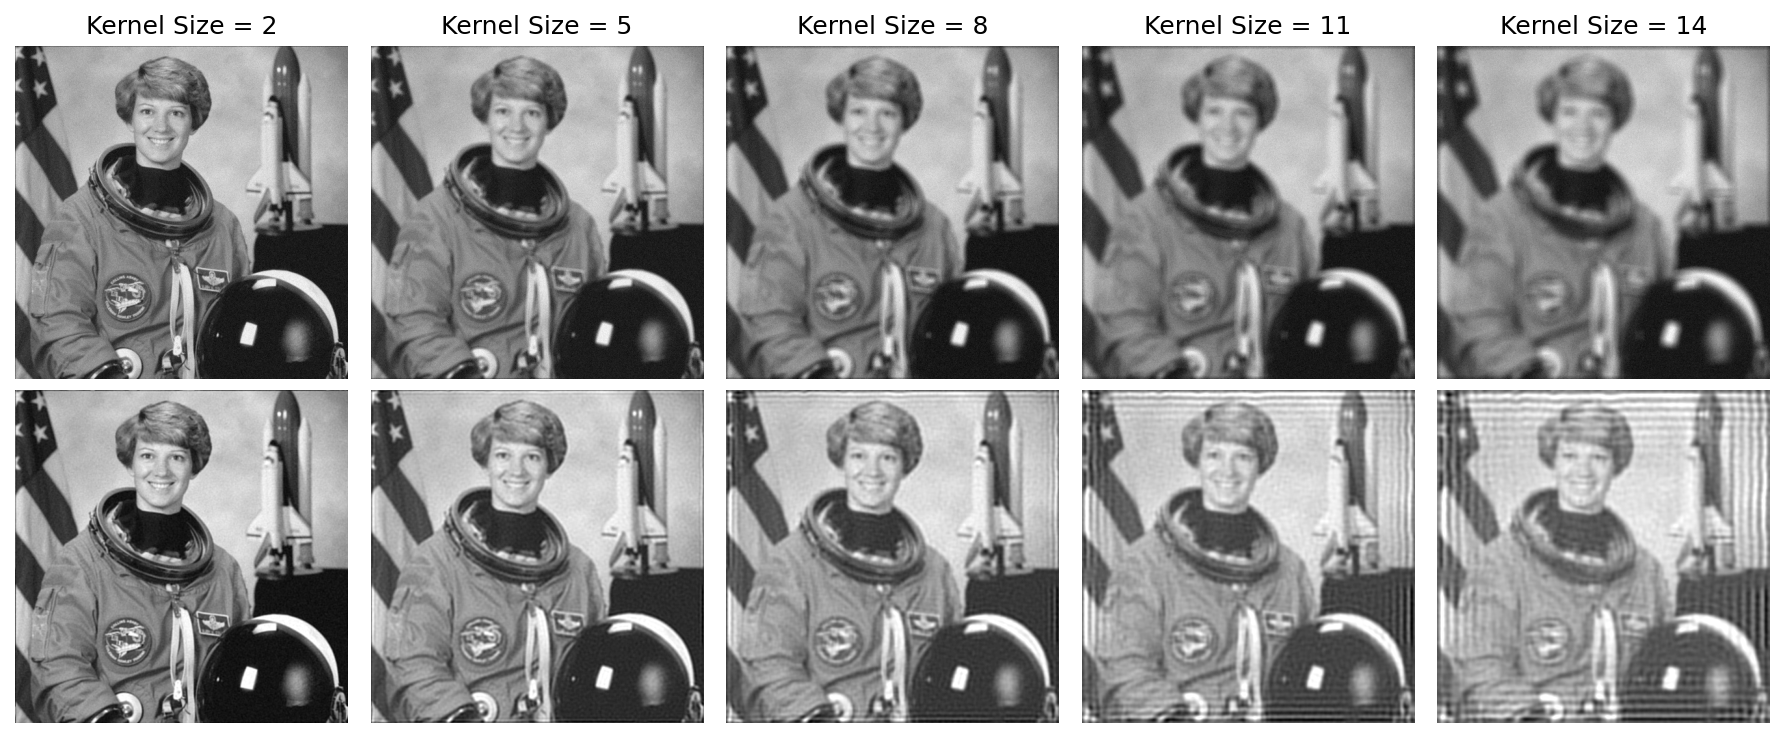

In [166]:
plt.figure(figsize = (12,5), dpi = 150)

for i in range(5):
    n = 2 + i*3
    img_ = color.rgb2gray(data.astronaut())
    psf = np.ones((n, n)) / n**2
    img = convolve2d(img_, psf, 'same')
    rng = np.random.default_rng()
    img += 0.1 * img.std() * rng.standard_normal(img.shape)
    deconvolved_img = restoration.wiener(img, psf, 0.1)

    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.title("Kernel Size = " + str(n))

    plt.subplot(2,5,6+i)
    plt.imshow(deconvolved_img, cmap = 'gray')
    plt.axis('off')

plt.tight_layout()

In [171]:
kernel_size = 5
kernel_h = np.zeros((kernel_size, kernel_size))
kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
kernel_h /= kernel_size
kernel_h

array([[0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0.2, 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ]])

In [192]:
def blur_edge(img, d=31):
    h, w  = img.shape[:2]
    img_pad = cv2.copyMakeBorder(img, d, d, d, d, cv2.BORDER_WRAP)
    img_blur = cv2.GaussianBlur(img_pad, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
    y, x = np.indices((h, w))
    dist = np.dstack([x, w-x-1, y, h-y-1]).min(-1)
    w = np.minimum(np.float32(dist)/d, 1.0)
    return img*w + img_blur*(1-w)

def motion_kernel(angle, d, sz=65):
    kern = np.ones((1, d), np.float32)
    c, s = np.cos(angle), np.sin(angle)
    A = np.float32([[c, -s, 0], [s, c, 0]])
    sz2 = sz // 2
    A[:,2] = (sz2, sz2) - np.dot(A[:,:2], ((d-1)*0.5, 0))
    kern = cv2.warpAffine(kern, A, (sz, sz), flags=cv2.INTER_CUBIC)
    return kern

def defocus_kernel(d, sz=65):
    kern = np.zeros((sz, sz), np.uint8)
    cv2.circle(kern, (sz, sz), d, 255, -1, cv2.LINE_AA, shift=1)
    kern = np.float32(kern) / 255.0
    return kern

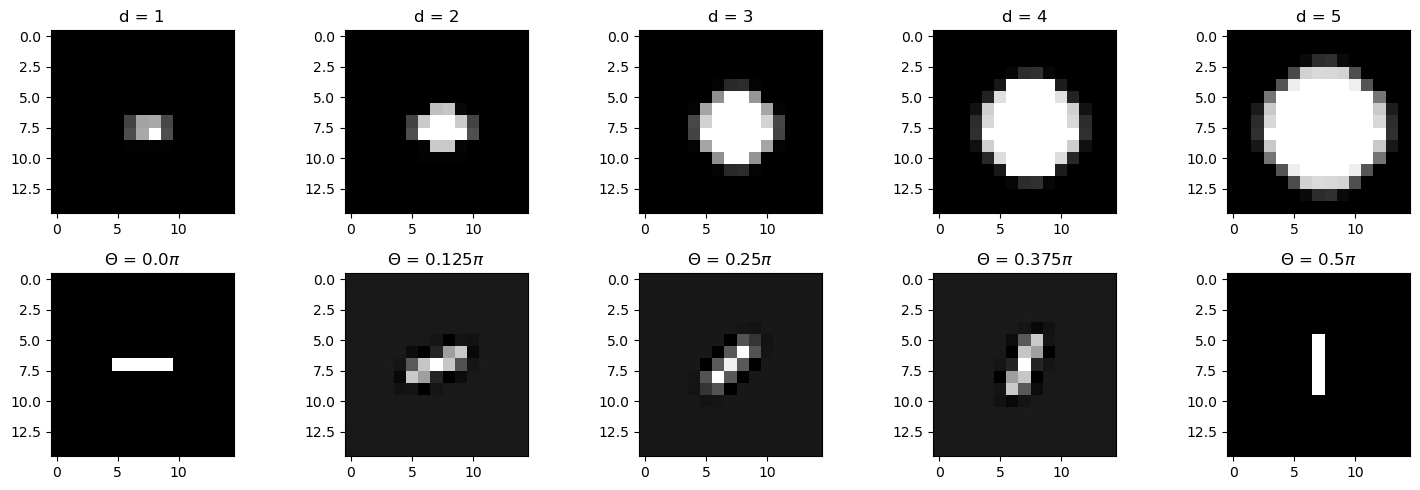

In [206]:
plt.figure(figsize = (15,5), dpi = 100)
for i in range(5):
    plt.subplot(2,5,i+1)
    kernel = defocus_kernel(d = i*2+1, sz=15)
    plt.imshow(kernel, cmap = 'gray')
    plt.title("d = " + str(i+1))
    
    plt.subplot(2,5,i+6)
    kernel = motion_kernel(angle = -(i)*np.pi/8 ,d = 5, sz=15)
    plt.imshow(kernel, cmap = 'gray')
    plt.title("$\Theta$ = " + str(i/8) + "$\pi$")
    
plt.tight_layout()

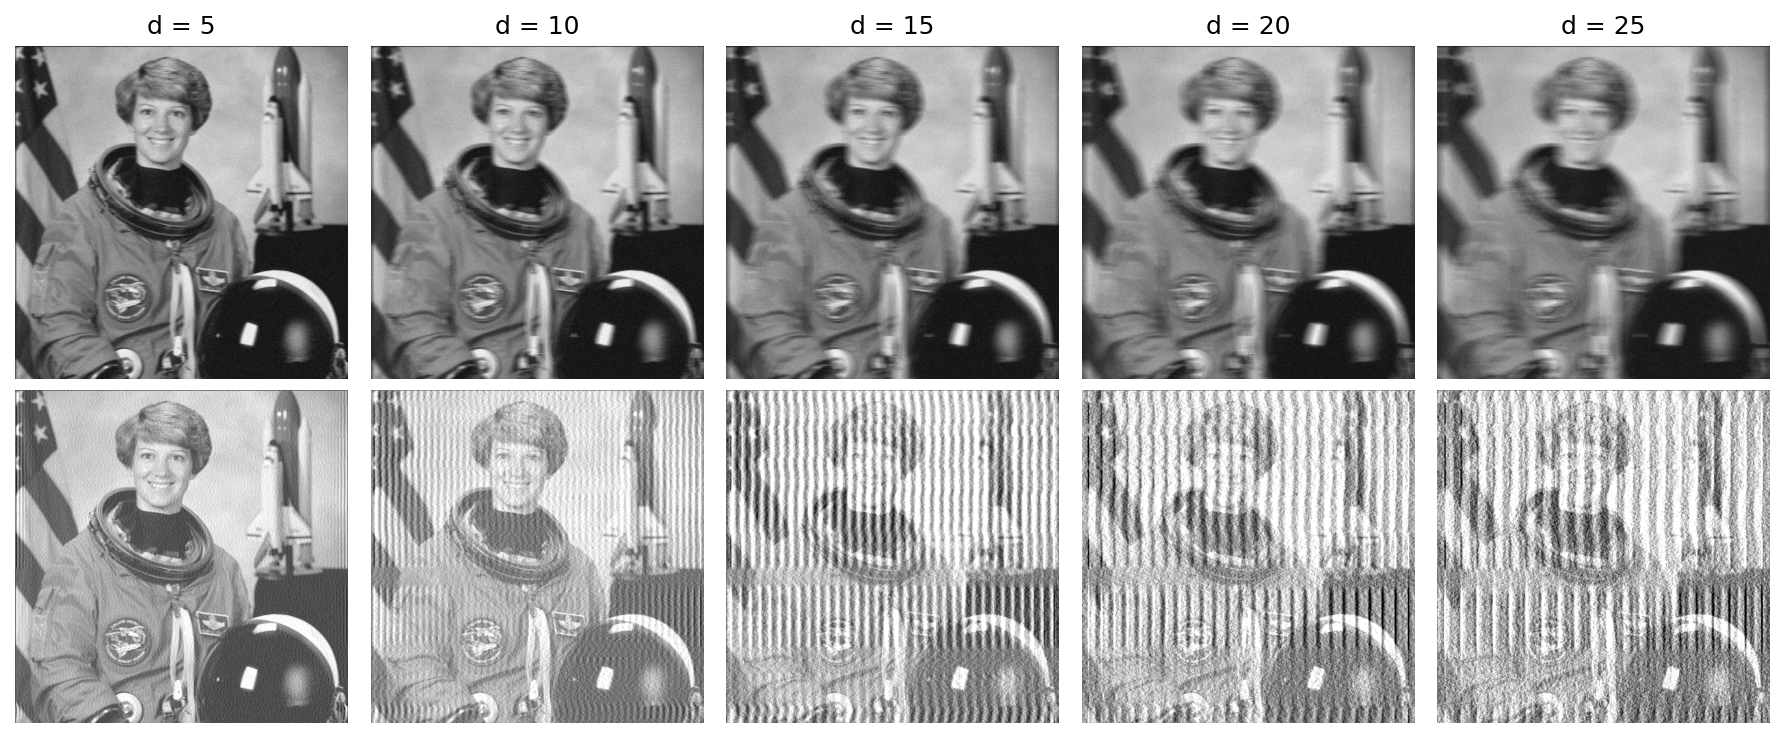

In [218]:
plt.figure(figsize = (12,5), dpi = 150)

for i in range(1,6):
    d = i*5
    img_ = 'cup1.jpg'
    psf = motion_kernel(angle = 0, d = d, sz=50)
    img = convolve2d(img_, psf, 'same')
    rng = np.random.default_rng()
    img += 0.1 * img.std() * rng.standard_normal(img.shape)
    deconvolved_img = restoration.wiener(img, psf, 0.1)

    plt.subplot(2,5,i)
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.title("d = " + str(d))

    plt.subplot(2,5,5+i)
    plt.imshow(deconvolved_img, cmap = 'gray')
    plt.axis('off')

plt.tight_layout()

In [ ]:
plt.figure(figsize = (12,5), dpi = 150)

fn = 'cup1.jpg'
img_ = cv2.imread(fn,cv2.IMREAD_GRAYSCALE)

for i in range(1,6):
    d = i*3
    psf = motion_kernel(angle = 0, d = d, sz=30)
    img = convolve2d(img_, psf, 'same')
    rng = np.random.default_rng()
    img += 0.1 * img.std() * rng.standard_normal(img.shape)
    deconvolved_img = restoration.wiener(img, psf, 0.1)

    plt.subplot(2,5,i)
    plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    plt.title("d = " + str(d))

    plt.subplot(2,5,5+i)
    plt.imshow(deconvolved_img, cmap = 'gray')
    plt.axis('off')

plt.tight_layout()

In [23]:
# def Rec(w,h): #rectangle
#     L = 160
#     aperture = np.zeros(shape = (L,L), dtype = float)
#     center = (L/2,L/2)
#     for i in np.arange(center[0]-w//2,center[0]+w//2): #width
#         for j in np.arange(center[1]-h//2,center[1]+h//2) : #height
#             aperture[int(i)][int(j)] = 1
            
#     return aperture

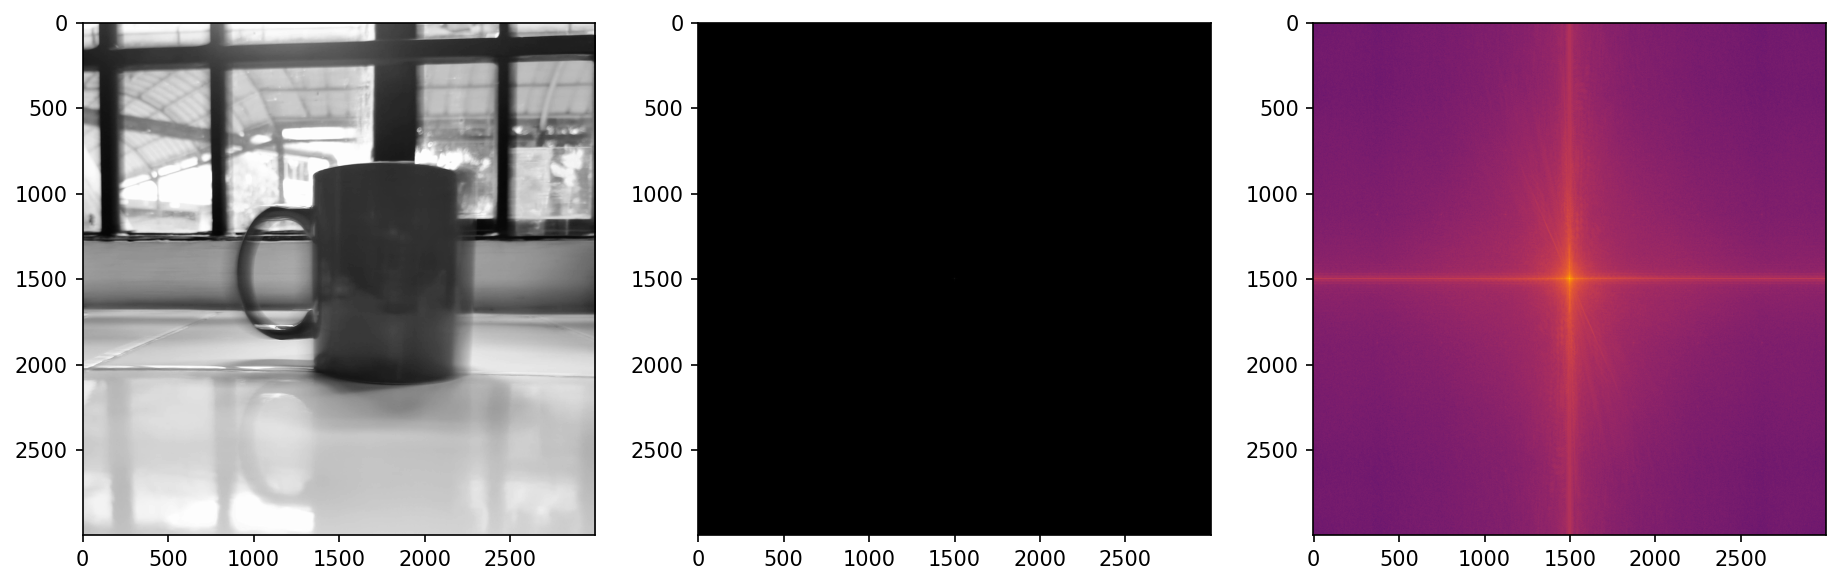

In [82]:
# fn = 'image138 copy.jpg'
fn = 'cup1.jpg'

f_xy = cv2.imread(fn,cv2.IMREAD_GRAYSCALE)
F_UV = fft2(f_xy)
F_img = fftshift(np.abs(F_UV))

cmap = 'gray'
plt.figure(dpi = 150, figsize = (15,5))
plt.subplot(131)
plt.imshow(f_xy, cmap = cmap)
plt.subplot(132)
plt.imshow(F_img, cmap = cmap)
plt.subplot(133)
plt.imshow(np.log(F_img), cmap ='inferno')

/var/folders/rk/gz59x8xx0bz69pn391mjkglw0000gn/T/ipykernel_16127/1095637948.py:20: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(H_img), cmap ='inferno')


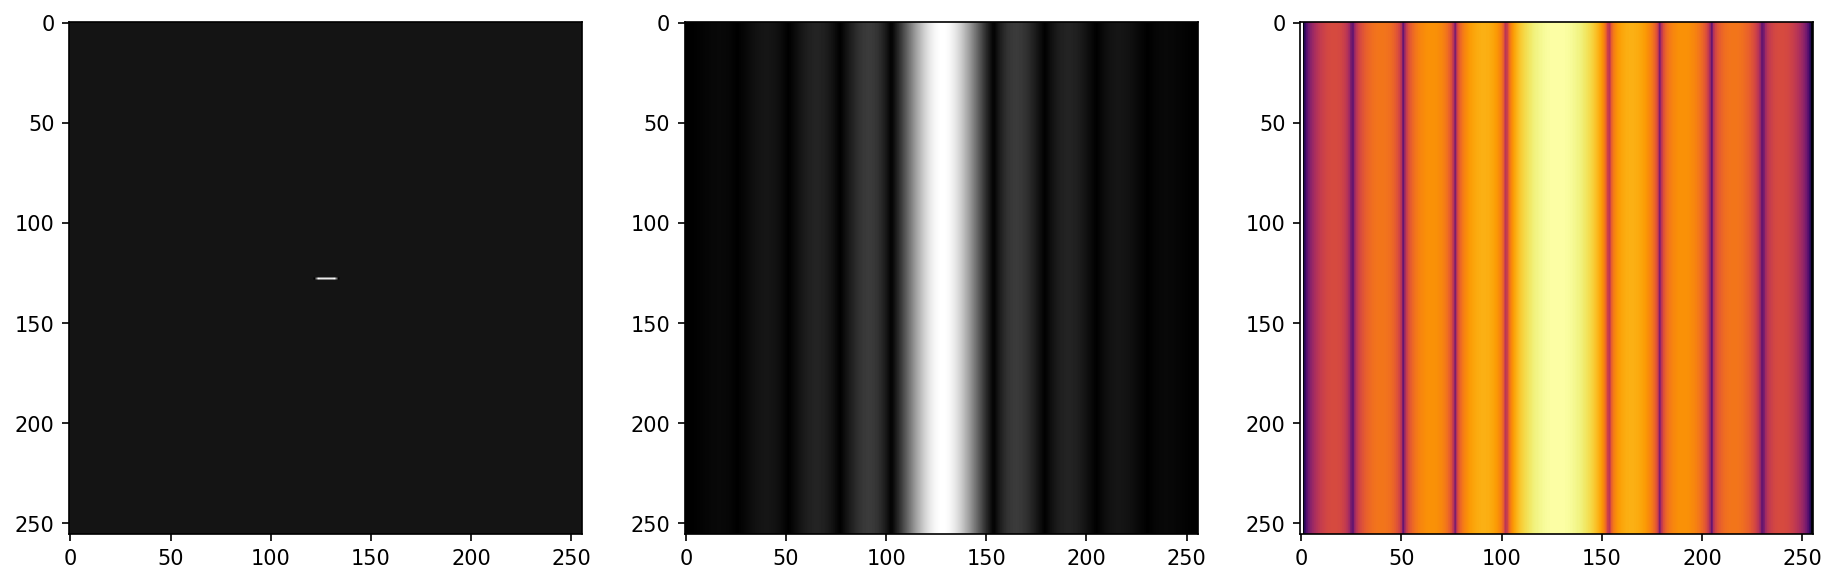

In [83]:
def motion_kernel(angle, d, sz):
    kern = np.ones((1, d), np.float32)
    c, s = np.cos(angle), np.sin(angle)
    A = np.float32([[c, -s, 0], [s, c, 0]])
    sz2 = sz // 2
    A[:,2] = (sz2, sz2) - np.dot(A[:,:2], ((d-1)*0.5, 0))
    kern = cv2.warpAffine(kern, A, (sz, sz), flags=cv2.INTER_CUBIC)
    return kern

h_xy = motion_kernel(0, 10, sz=256)
H_UV = fft2(h_xy)
H_img = fftshift(np.abs(H_UV))

plt.figure(dpi = 150, figsize = (15,5))
plt.subplot(131)
plt.imshow(h_xy, cmap = cmap)
plt.subplot(132)
plt.imshow(H_img, cmap = cmap)
plt.subplot(133)
plt.imshow(np.log(H_img), cmap ='inferno')

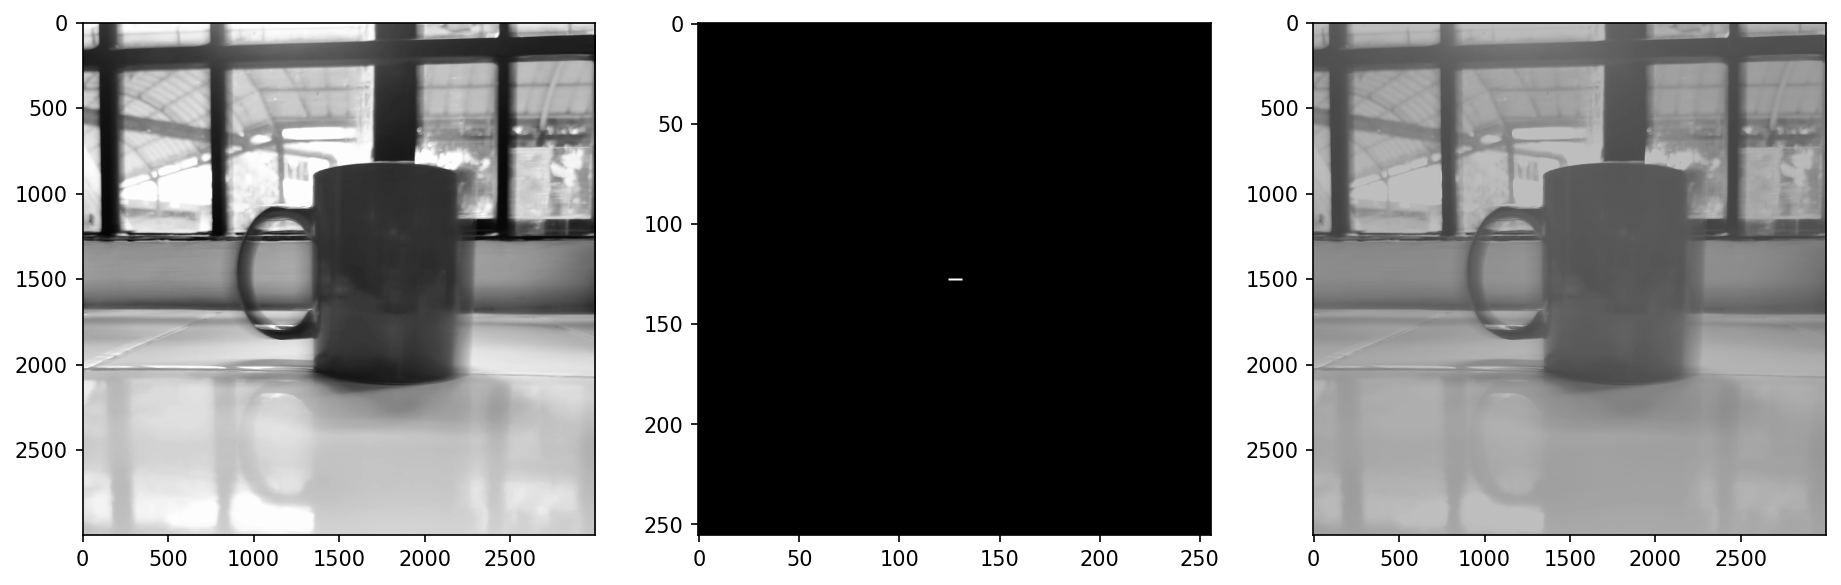

In [104]:
h_xy = motion_kernel(0, 7, sz=256)
H_UV = fft2(h_xy)
H_img = fftshift(np.abs(H_UV))

deconvolved = restoration.wiener(f_xy, h_xy, 1, clip=False)
plt.figure(dpi = 150, figsize = (15,5))
plt.subplot(131)
plt.imshow(f_xy, cmap = cmap)
plt.subplot(132)
plt.imshow(h_xy, cmap = cmap)
plt.subplot(133)
plt.imshow(deconvolved, cmap = cmap)

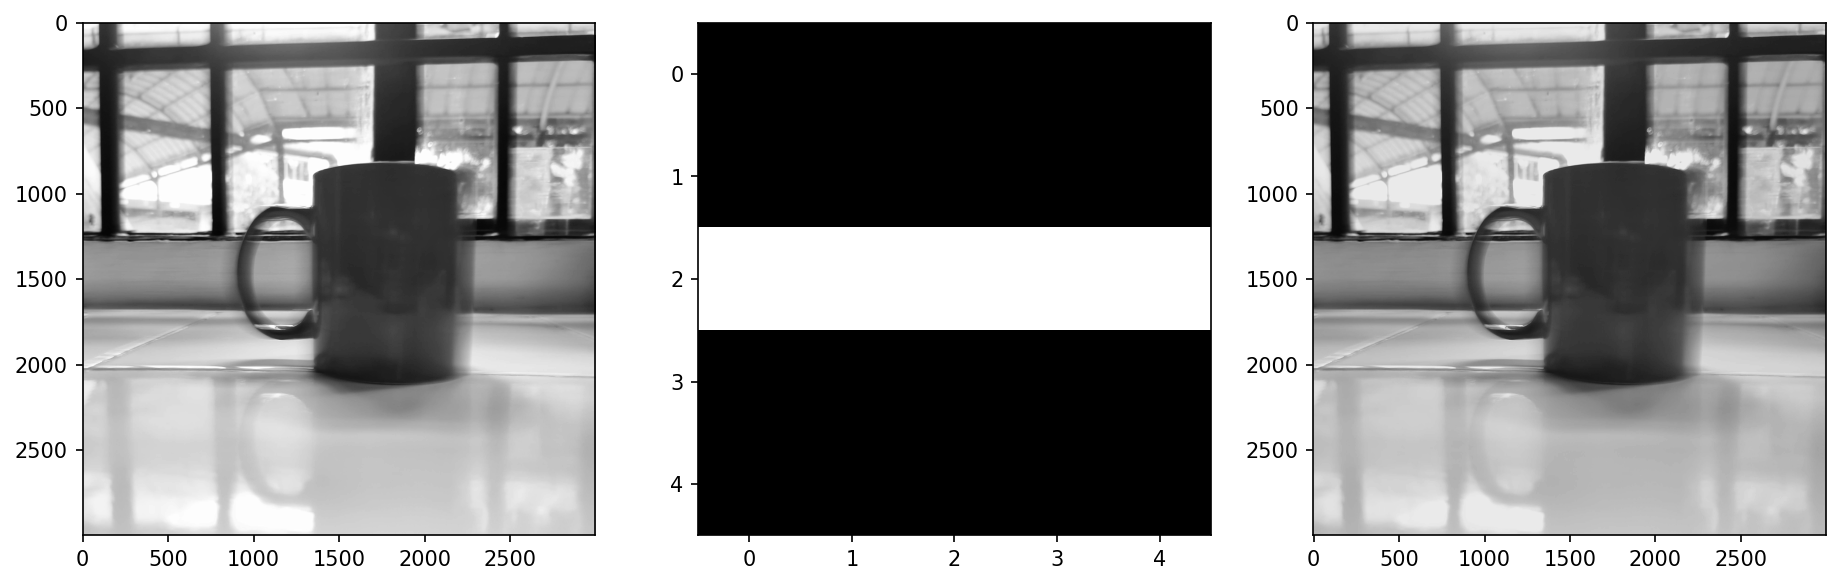

In [111]:
kernel_size = 5
kernel_h = np.zeros((kernel_size, kernel_size))
kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
kernel_h /= kernel_size

h_xy = kernel_h
L = 3
psf = np.ones((L, L)) / (L*L)

deconvolved = restoration.wiener(f_xy, h_xy, 0.5, clip=False)
# deconvolved = restoration.wiener(f_xy, h_xy, 0.2, clip=False)
plt.figure(dpi = 150, figsize = (15,5))
plt.subplot(131)
plt.imshow(f_xy, cmap = cmap)
plt.subplot(132)
plt.imshow(h_xy, cmap = cmap)
plt.subplot(133)
plt.imshow(deconvolved, cmap = cmap)

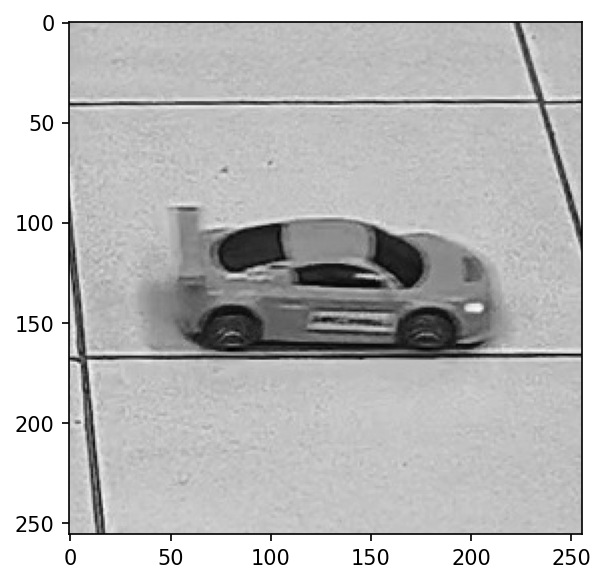

In [64]:
h_xy = motion_kernel(0, 1, sz=256)
H_UV = fft2(h_xy)
H_img = fftshift(np.abs(H_UV))

plt.figure(dpi = 150, figsize = (15,5))
plt.subplot(131)
plt.imshow(np.abs(fftshift(ifft2(F_UV/H_UV))), cmap = cmap)
# plt.subplot(132)
# plt.imshow(H_img, cmap = cmap)
# plt.subplot(133)
# plt.imshow(np.log(H_img), cmap ='inferno')

In [60]:

kernel_size = 2
kernel_h = np.zeros((kernel_size, kernel_size))
kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
kernel_h /= kernel_size

L = 3
psf = np.ones((L, L)) / (L*L)
psf

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

In [ ]:
    C = fftshift(aperture)
    Conv = np.abs(ifft2(V*C))

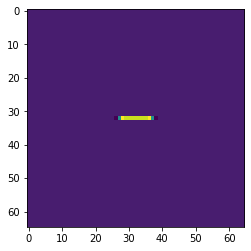

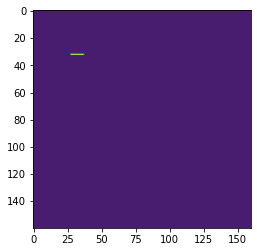

In [156]:
img_bw = cv2.imread(fn, 0)
img_bw = np.float32(img_bw)/255.0

ang = 0
d = 10
psf = motion_kernel(ang, d)
psf /= psf.sum()
plt.imshow(psf)
plt.show()
psf_pad = np.zeros_like(img_bw)
kh, kw = psf.shape
psf_pad[:kh, :kw] = psf
plt.imshow(psf_pad)
plt.show()

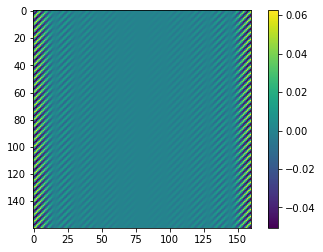

In [163]:
IMG_BW = cv2.dft(img_bw, flags=cv2.DFT_COMPLEX_OUTPUT)


noise = 15
PSF = cv2.dft(psf_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)
PSF2 = (PSF**2).sum(-1)
iPSF = PSF / (PSF2 + noise)[...,np.newaxis]

plt.imshow(iPSF[:,:,0])
plt.colorbar()

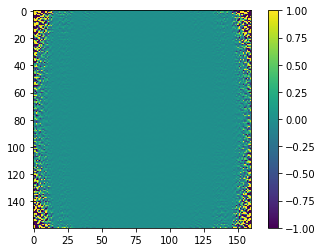

In [170]:
RES_BW = cv2.mulSpectrums(IMG_BW, iPSF, 0)
plt.imshow(RES_BW[:,:,0], vmin = -1, vmax = 1)
plt.colorbar()

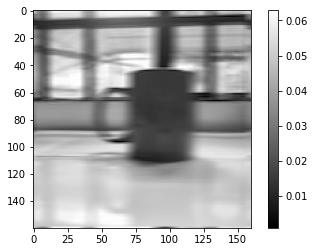

In [175]:
res_bw = cv2.idft(RES_BW, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
res_bw = np.roll(res_bw, -kh//2, 0)
res_bw = np.roll(res_bw, -kw//2, 1)
plt.imshow(res_bw, cmap = 'gray')
plt.colorbar()

In [196]:
def deblurring(fn, d, angle, noise):
    img_bw = cv2.imread(fn, 0)
    img_bw = np.float32(img_bw)/255.0
    psf = motion_kernel(angle, d)
    psf /= psf.sum()
    psf_pad = np.zeros_like(img_bw)
    kh, kw = psf.shape
    psf_pad[:kh, :kw] = psf

    IMG_BW = cv2.dft(img_bw, flags=cv2.DFT_COMPLEX_OUTPUT)
    PSF = cv2.dft(psf_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)
    PSF2 = (PSF**2).sum(-1)
    iPSF = PSF / (PSF2 + noise)[...,np.newaxis]


    RES_BW = cv2.mulSpectrums(IMG_BW, iPSF, 0)
    res_bw = cv2.idft(RES_BW, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
    res_bw = np.roll(res_bw, -kh//2, 0)
    res_bw = np.roll(res_bw, -kw//2, 1)
    
    plt.suptitle('d = ' + str(d))
    plt.subplot(121)
    plt.imshow(img_bw, cmap = 'gray')
    plt.subplot(122)
    plt.imshow(res_bw, cmap = 'gray')
    plt.show()

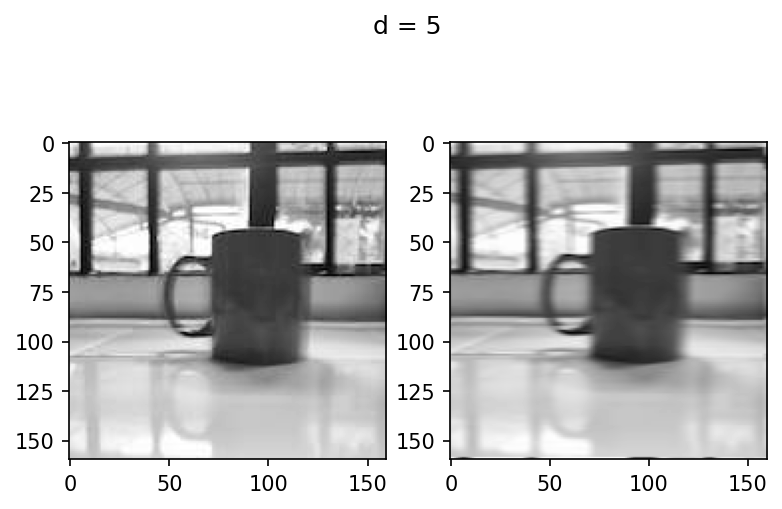

In [209]:
plt.figure(dpi = 150)
deblurring(fn = 'cup_blur_2 copy.jpg',d = 5, angle = 0, noise = 12)

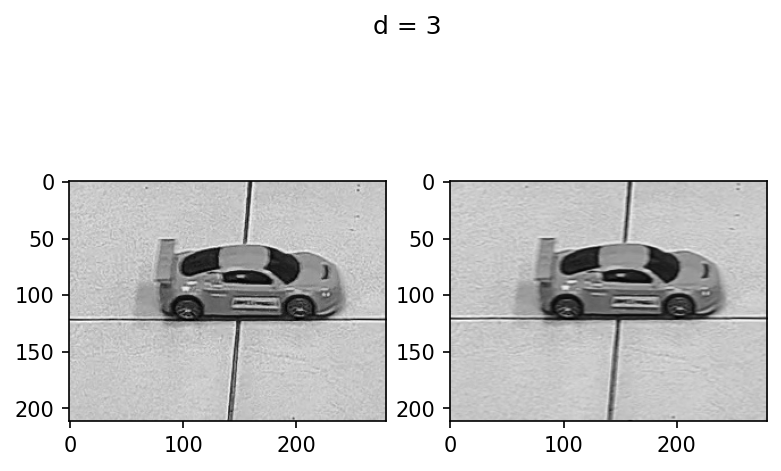

In [217]:
plt.figure(dpi = 150)
deblurring(fn = 'image18.jpg',d = 3, angle = 0, noise = 4)

In [139]:
img_r = np.zeros_like(img_bw)
img_g = np.zeros_like(img_bw)
img_b = np.zeros_like(img_bw)

img_r = img_rgb[..., 0]
img_g = img_rgb[..., 1]
img_b = img_rgb[..., 2]

img_rgb = np.float32(img_rgb)/255.0
img_bw = np.float32(img_bw)/255.0
img_r = np.float32(img_r)/255.0
img_g = np.float32(img_g)/255.0
img_b = np.float32(img_b)/255.0

img_r = blur_edge(img_r)
img_g = blur_edge(img_g)
img_b = blur_edge(img_b)

# IMG_BW = cv2.dft(img_bw, flags=cv2.DFT_COMPLEX_OUTPUT)
IMG_R = cv2.dft(img_r, flags=cv2.DFT_COMPLEX_OUTPUT)
IMG_G = cv2.dft(img_g, flags=cv2.DFT_COMPLEX_OUTPUT)
IMG_B = cv2.dft(img_b, flags=cv2.DFT_COMPLEX_OUTPUT)


TypeError: Invalid shape (160, 160, 2) for image data

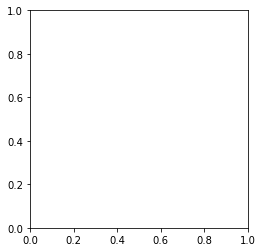

In [140]:
plt.imshow(IMG_R)

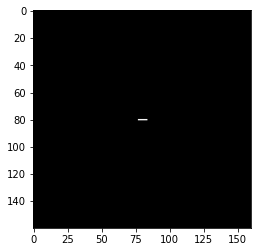

Text(0.5, 1.0, 'FFT')

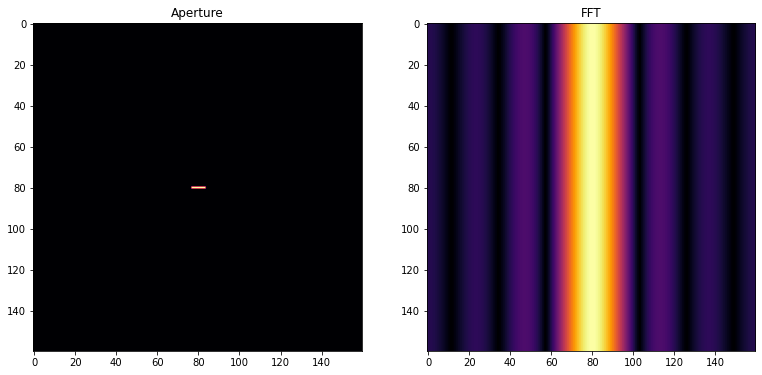

In [220]:
aperture = psf
f = plt.figure(figsize=(20,60))
ax1 = f.add_subplot(131)
ax1.imshow(aperture, cmap ='inferno')
plt.title('Aperture')
ft_aperture = fft2(aperture)
FT_aperture = fftshift(np.abs(ft_aperture))
ax2 = f.add_subplot(132)
ax2.imshow(FT_aperture, cmap ='inferno')
plt.title('FFT')

In [221]:
def FFT(aperture):
    f = plt.figure(figsize=(20,60))
    ax1 = f.add_subplot(131)
    ax1.imshow(aperture, cmap ='inferno')
    plt.title('Aperture')
    ft_aperture = fft2(aperture)
    FT_aperture = fftshift(np.abs(ft_aperture))
    ax2 = f.add_subplot(132)
    ax2.imshow(FT_aperture, cmap ='inferno')
    plt.title('FFT')
    ax3 = f.add_subplot(133)
    ax3.imshow(np.log(FT_aperture), cmap ='inferno')
    plt.title('FFT in log scale')
    

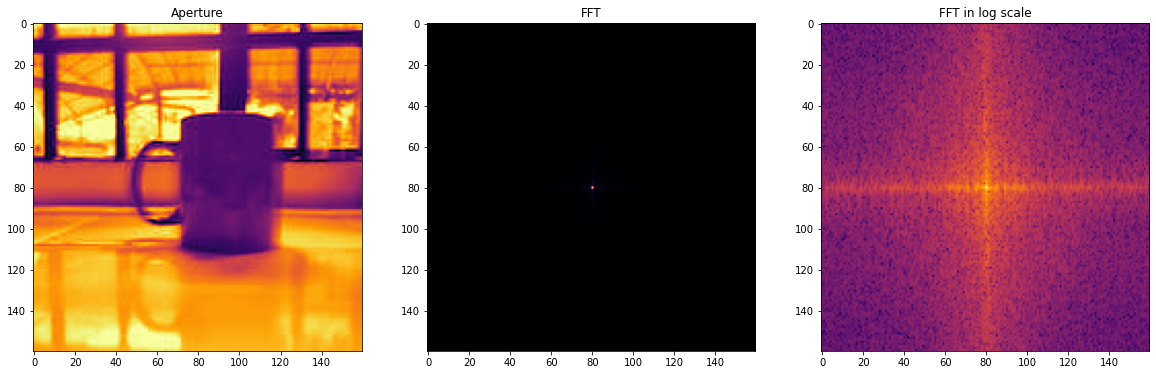

In [222]:
FFT(img)

In [223]:
def Conv(img, aperture):
    f = plt.figure(figsize=(20,60))
    C = fftshift(aperture)
    V = fft2(img)
    Conv = np.abs(ifft2(V*C))
    plt.subplot(131)
    plt.imshow(img, cmap ='inferno')
    plt.subplot(132)
    plt.imshow(aperture, cmap ='inferno')
    plt.subplot(133)
    plt.imshow(Conv, cmap ='inferno')

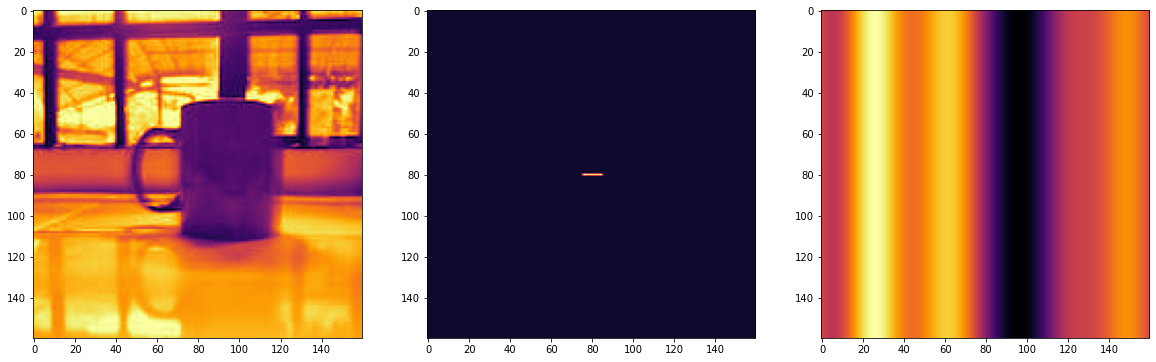

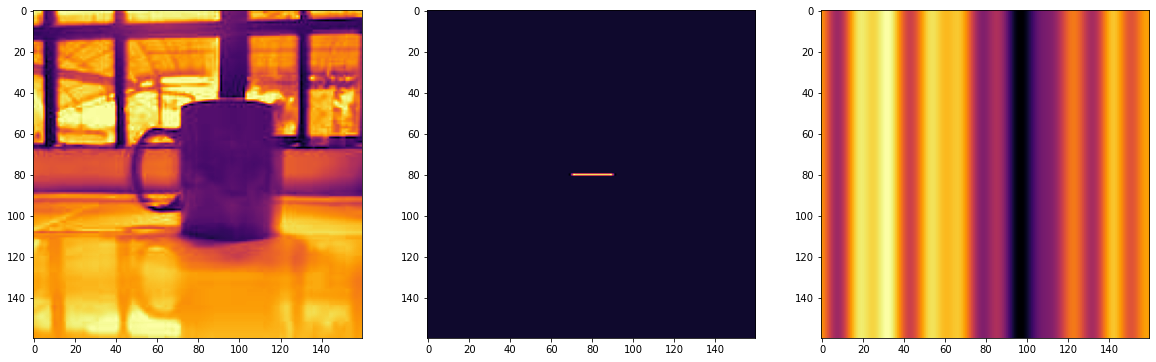

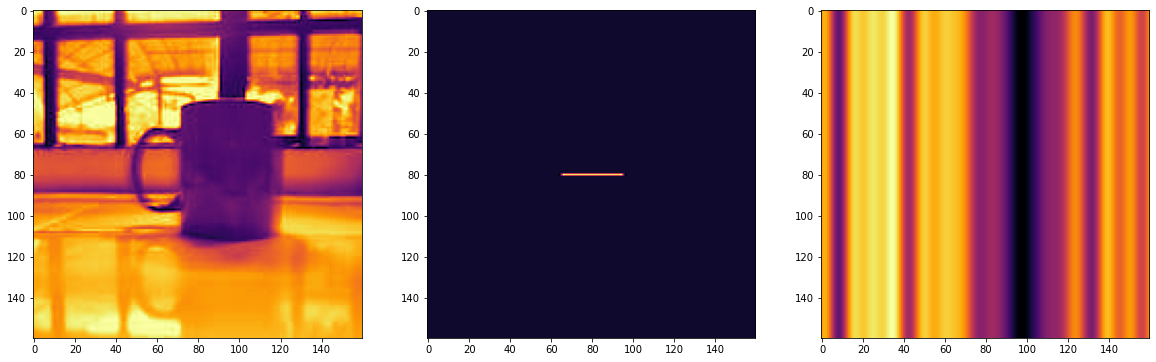

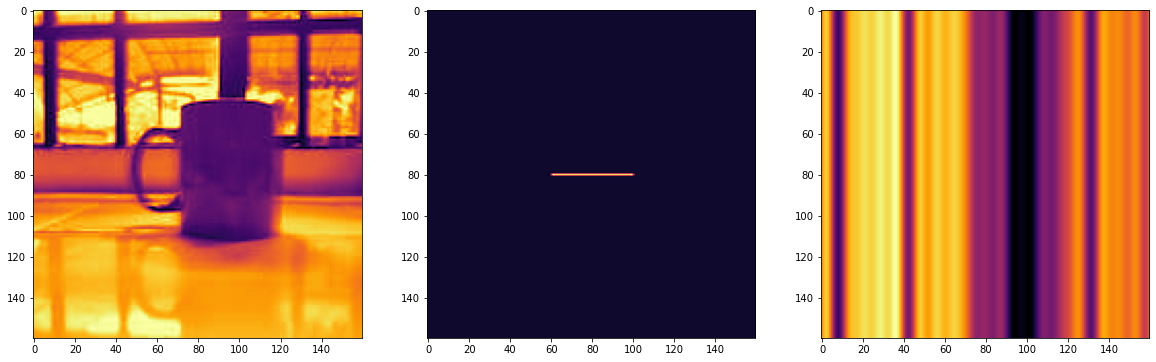

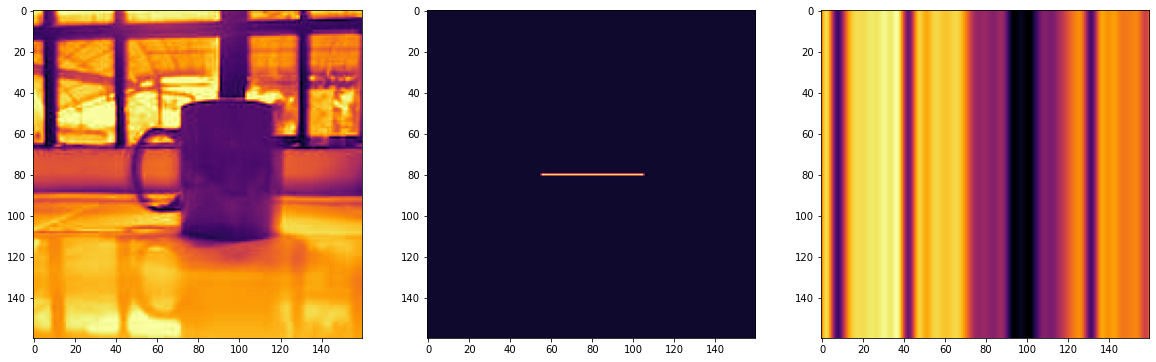

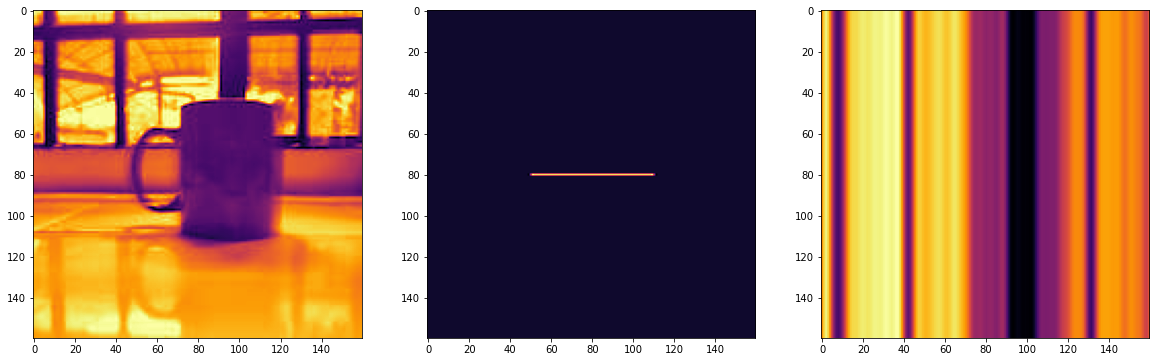

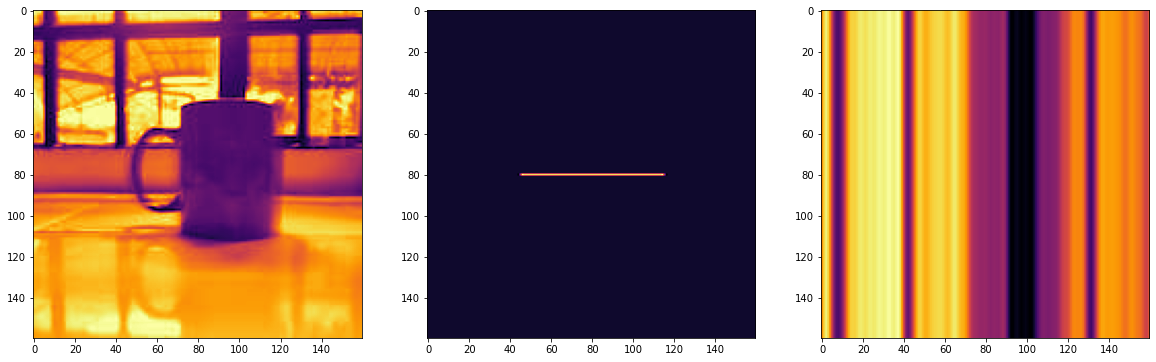

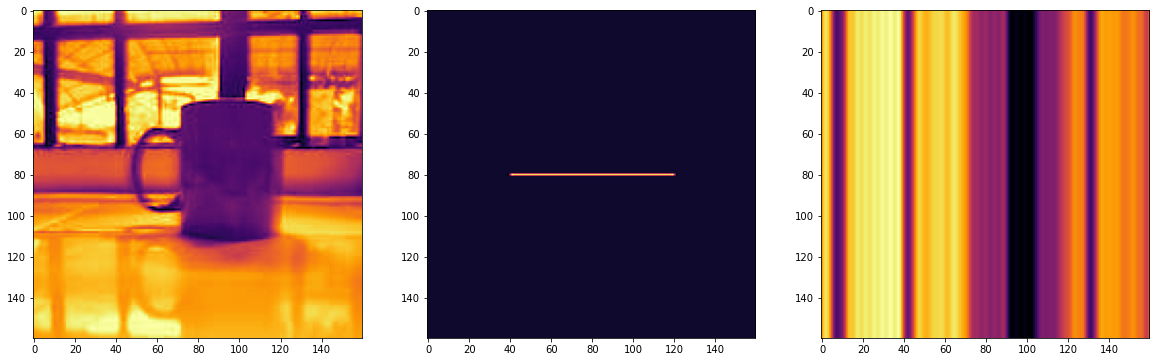

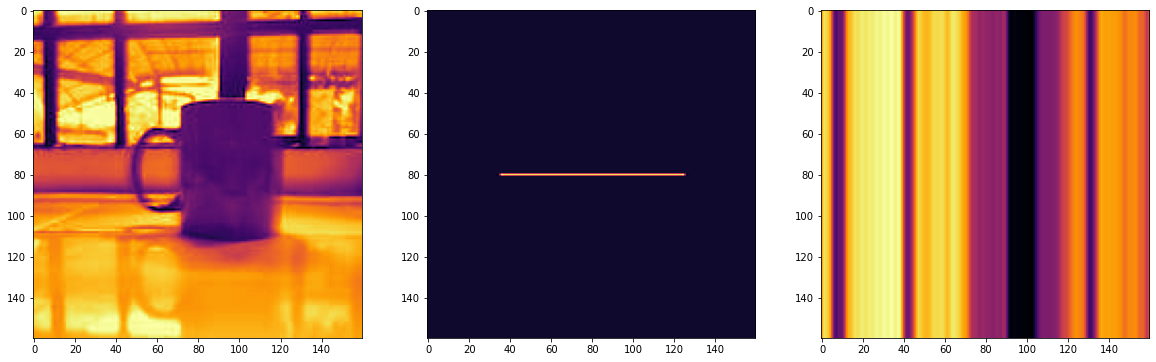

In [224]:
for i in range(1,10):
    psf = motion_kernel(0, i*10, sz=160)
    Conv(img, psf)

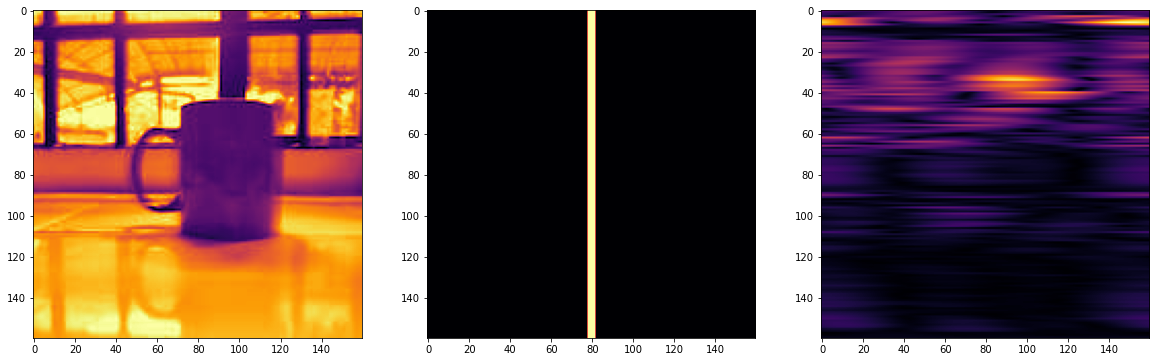

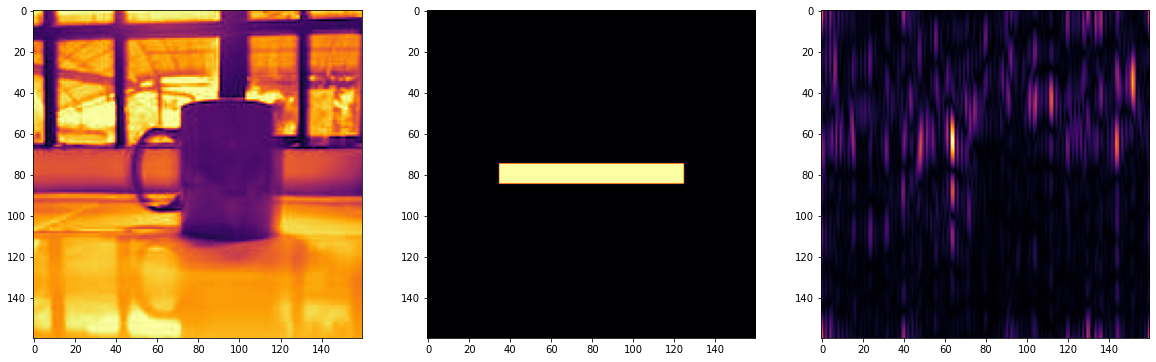

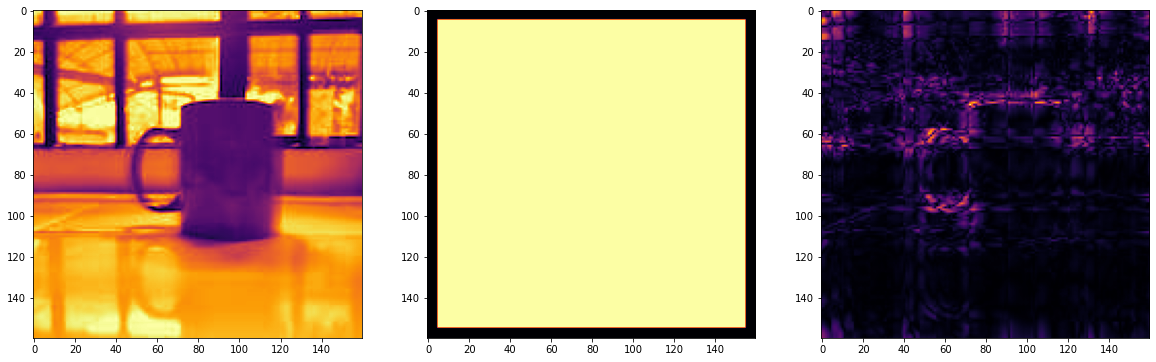

In [242]:
def Edge2(aperture):
    f = plt.figure(figsize=(20,60))
    C = aperture
    V = fft2(img)
    Conv = np.abs(ifft2(V*C))
    plt.subplot(131)
    plt.imshow(img, cmap = 'inferno')
    plt.subplot(132)
    plt.imshow(C, cmap = 'inferno')
    plt.subplot(133)
    plt.imshow(Conv, cmap = 'inferno')
    
Edge2(Rec(160,4))
Edge2(Rec(10, 90))
Edge2(Rec(150,150))

In [80]:
Rec(160,85)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [87]:
import numpy as np
from scipy.signal import fftconvolve

def richardson_lucy_blind(image, psf, original, num_iter=50):    
    im_deconv = np.full(image.shape, 0.1, dtype='float')    # init output
    for i in range(num_iter):
        psf_mirror = np.flip(psf)
        conv = fftconvolve(im_deconv, psf, mode='same')
        relative_blur = image / conv
        im_deconv *= fftconvolve(relative_blur, psf_mirror, mode='same')
        im_deconv_mirror = np.flip(im_deconv)
        psf *= fftconvolve(relative_blur, im_deconv_mirror, mode='same')    
    return im_deconv

In [92]:

xx = richardson_lucy_blind(img, psf, img, num_iter=50)

/var/folders/rk/gz59x8xx0bz69pn391mjkglw0000gn/T/ipykernel_14164/1547346938.py:12: RuntimeWarning: overflow encountered in multiply
  psf *= fftconvolve(relative_blur, im_deconv_mirror, mode='same')


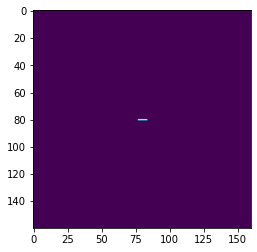

In [94]:
psf = motion_kernel(0, 7, sz=160)

plt.imshow(psf)

In [243]:
import numpy as np
import cv2
from common import nothing


def blur_edge(img, d=31):
    h, w  = img.shape[:2]
    img_pad = cv2.copyMakeBorder(img, d, d, d, d, cv2.BORDER_WRAP)
    img_blur = cv2.GaussianBlur(img_pad, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
    y, x = np.indices((h, w))
    dist = np.dstack([x, w-x-1, y, h-y-1]).min(-1)
    w = np.minimum(np.float32(dist)/d, 1.0)
    return img*w + img_blur*(1-w)

def motion_kernel(angle, d, sz=65):
    kern = np.ones((1, d), np.float32)
    c, s = np.cos(angle), np.sin(angle)
    A = np.float32([[c, -s, 0], [s, c, 0]])
    sz2 = sz // 2
    A[:,2] = (sz2, sz2) - np.dot(A[:,:2], ((d-1)*0.5, 0))
    kern = cv2.warpAffine(kern, A, (sz, sz), flags=cv2.INTER_CUBIC)
    return kern

def defocus_kernel(d, sz=65):
    kern = np.zeros((sz, sz), np.uint8)
    cv2.circle(kern, (sz, sz), d, 255, -1, cv2.CV_AA, shift=1)
    kern = np.float32(kern) / 255.0
    return kern
    

if __name__ == '__main__':
    print(__doc__)
    import sys, getopt
    opts, args = getopt.getopt(sys.argv[1:], '', ['circle', 'angle=', 'd=', 'snr='])
    opts = dict(opts)
    try: fn = args[0]
    except: fn = 'data/licenseplate_motion.jpg'

    win = 'deconvolution'
    
    img = cv2.imread(fn, 0)
    img = np.float32(img)/255.0
    cv2.imshow('input', img)

    img = blur_edge(img)
    IMG = cv2.dft(img, flags=cv2.DFT_COMPLEX_OUTPUT)

    defocus = '--circle' in opts

    def update(_):
        ang = np.deg2rad( cv2.getTrackbarPos('angle', win) )
        d = cv2.getTrackbarPos('d', win)
        noise = 10**(-0.1*cv2.getTrackbarPos('SNR (db)', win))

        if defocus:
            psf = defocus_kernel(d)
        else:
            psf = motion_kernel(ang, d)
        cv2.imshow('psf', psf)

        psf /= psf.sum()
        psf_pad = np.zeros_like(img)
        kh, kw = psf.shape
        psf_pad[:kh, :kw] = psf
        PSF = cv2.dft(psf_pad, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)
        PSF2 = (PSF**2).sum(-1)
        iPSF = PSF / (PSF2 + noise)[...,np.newaxis]
        RES = cv2.mulSpectrums(IMG, iPSF, 0)
        res = cv2.idft(RES, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT )
        res = np.roll(res, -kh//2, 0)
        res = np.roll(res, -kw//2, 1)
        cv2.imshow(win, res)

    cv2.namedWindow(win)
    cv2.namedWindow('psf', 0)
    cv2.createTrackbar('angle', win, int(opts.get('--angle', 135)), 180, update)
    cv2.createTrackbar('d', win, int(opts.get('--d', 22)), 50, update)
    cv2.createTrackbar('SNR (db)', win, int(opts.get('--snr', 25)), 50, update)
    update(None)

    while True:
        ch = cv2.waitKey()
        if ch == 27:
            break
        if ch == ord(' '):
            defocus = not defocus
            update(None)

ImportError: cannot import name 'nothing' from 'common' (/opt/anaconda3/lib/python3.9/site-packages/common/__init__.py)